In [ ]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setting path of directory
M_DIR =  "/content/drive/MyDrive/Monkey_Pox_Dataset/Train/Monkeypox/"
O_DIR = "/content/drive/MyDrive/Monkey_Pox_Dataset/Train/Others/"


# storing all the files from directories M_DIR and O_DIR to Mimages and Oimages for accessing images directly

Mimages = os.listdir(M_DIR)
Oimages = os.listdir(O_DIR)

## Sample Images

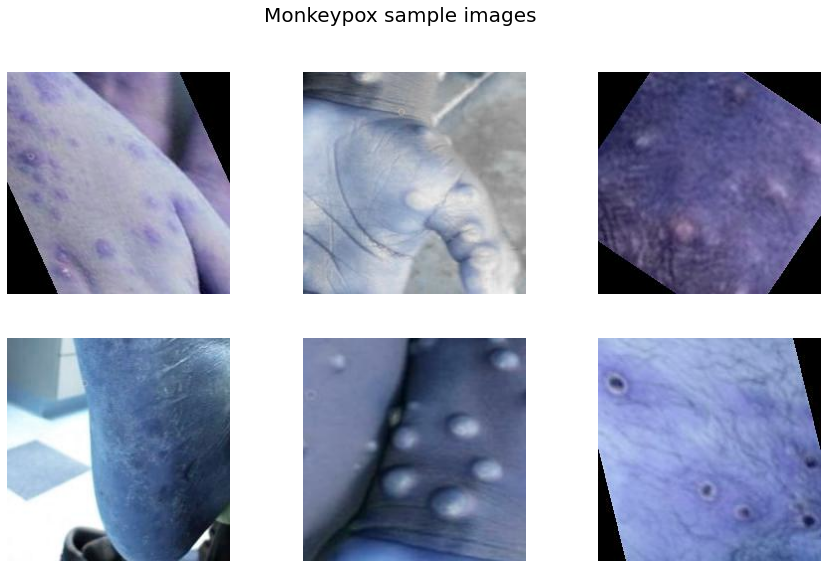

In [ ]:
sample_monkeypox = random.sample(Mimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(M_DIR +sample_monkeypox[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Monkeypox sample images',fontsize=20)
plt.show()

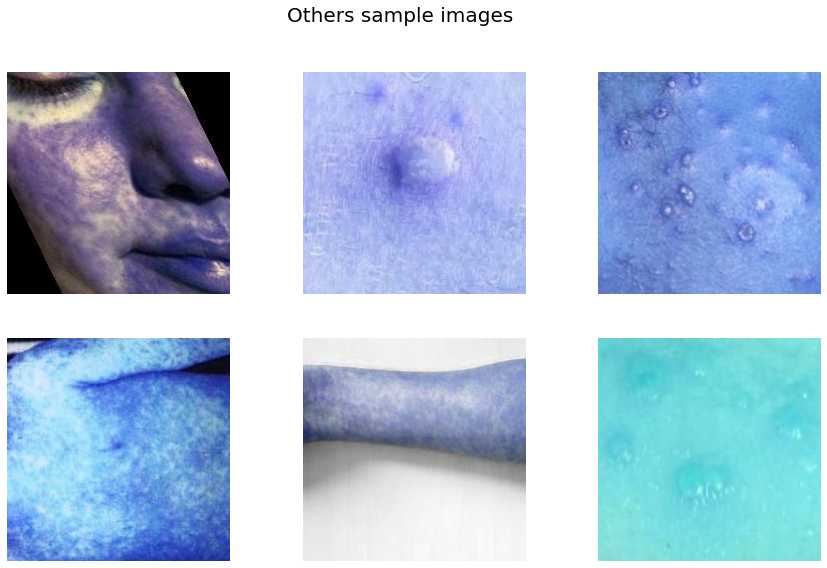

In [ ]:
sample_others = random.sample(Oimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread(O_DIR +sample_others[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Others sample images',fontsize=20)
plt.show()

## Data Preparation - Loading Images and Labels

In [ ]:
data=[]
labels=[]
for m in Mimages:
    try:
        image=cv2.imread(M_DIR+m)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(1)
    except AttributeError:
        print("")

for o in Oimages:
    try:
        image=cv2.imread(O_DIR+o)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        data.append(np.array(size_image))
        labels.append(0)
    except AttributeError:
        print("")

In [ ]:
#converting features and labels in array
feats=np.array(data)
labels=np.array(labels)

# saving features and labels for later re-use
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_train",feats)
np.save("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_train",labels)

In [ ]:
feats=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_train.npy")
labels=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_train.npy")

s=np.arange(feats.shape[0])
np.random.shuffle(s)
feats=feats[s]
labels=labels[s]

num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)

2142


In [ ]:
# splitting cells images into 80:20 ratio i.e., 80% for training and 20% for testing purpose
(x_train,x_test)=feats[(int)(0.2*len_data):],feats[:(int)(0.2*len_data)]

(y_train,y_test)=labels[(int)(0.2*len_data):],labels[:(int)(0.2*len_data)]

In [ ]:
x_train = x_train.astype('float32')/255 # As we are working on image data we are normalizing data by divinding 255.
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)


#Doing One hot encoding as classifier has multiple classes
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes)




In [ ]:
# Hyper parameters
epochs = 50
batch_size = 32

conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

In [ ]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [ ]:
# Define the optimizer
#optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [ ]:
checkpoint = ModelCheckpoint('.mdl_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)



callbacks = [checkpoint,reduce_lr]

In [ ]:
history = model.fit(x_train,y_train,batch_size=batch_size,callbacks=callbacks, validation_data=(x_test,y_test),epochs=epochs,verbose=1)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8092
Epoch 1: val_accuracy improved from -inf to 0.56075, saving model to .mdl_wts.hdf5
54/54 [==============================] - 15s 193ms/step - loss: 0.4192 - accuracy: 0.8092 - val_loss: 4.5847 - val_accuracy: 0.5607 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.8944
Epoch 2: val_accuracy improved from 0.56075 to 0.56542, saving model to .mdl_wts.hdf5
54/54 [==============================] - 10s 177ms/step - loss: 0.2635 - accuracy: 0.8944 - val_loss: 8.6900 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9072
Epoch 3: val_accuracy improved from 0.56542 to 0.58879, saving model to .mdl_wts.hdf5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 [==============================] - 10s 178ms/step - loss: 0.2201 - accuracy: 0.9072 - val_

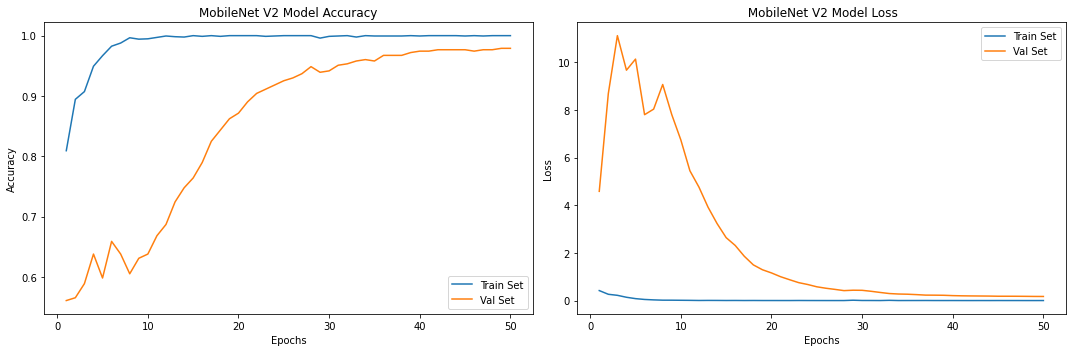

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# saving the weight of model
from numpy import loadtxt
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

#checking the score of the model
score=model.evaluate(x_test,y_test)
print(score)

14/14 [==============================] - 1s 29ms/step - loss: 0.1734 - accuracy: 0.9790
[0.17337840795516968, 0.9789719581604004]


In [ ]:
x_val=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/feats_val.npy")
y_val=np.load("/content/drive/MyDrive/Monkey_Pox_Dataset/labels_val.npy")

s=np.arange(x_val.shape[0])
np.random.shuffle(s)
x_val=x_val[s]
y_val=y_val[s]

x_val = x_val.astype('float32')/255
y_val=to_categorical(y_val,num_classes)

In [ ]:
# checking the accuracy of thr
accuracy = model.evaluate(x_val, y_val, verbose=1)
print('\n', 'Validation_Accuracy:-', accuracy[1])

14/14 [==============================] - 1s 35ms/step - loss: 1.7728 - accuracy: 0.7881

 Validation_Accuracy:- 0.788095235824585


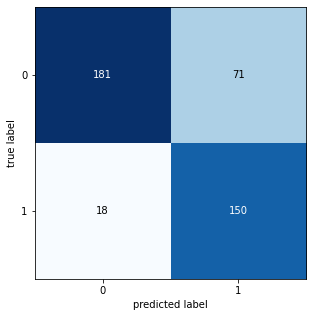

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_val)
pred = np.argmax(pred,axis = 1)
y_true = np.argmax(y_val,axis = 1)

#creating confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
# plotting confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
print('{}'.format(
                           classification_report(y_true , pred)))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80       252
           1       0.68      0.89      0.77       168

    accuracy                           0.79       420
   macro avg       0.79      0.81      0.79       420
weighted avg       0.82      0.79      0.79       420



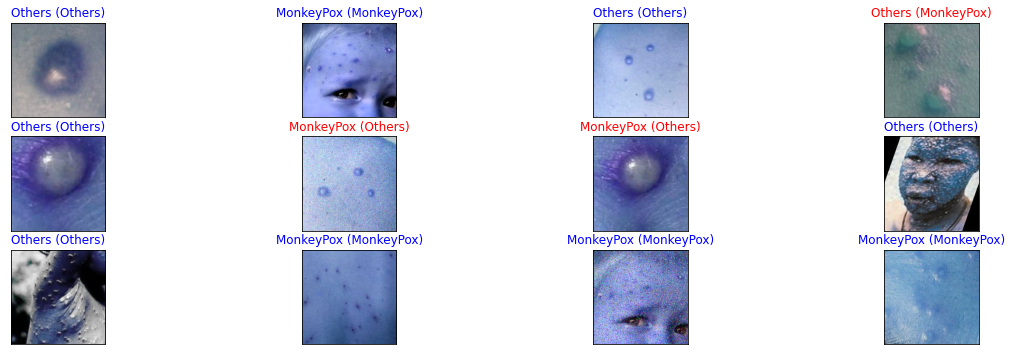

In [ ]:
y_hat = model.predict(x_val)

# define text labels
m_labels = ['MonkeyPox','Others']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_val.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_val[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_val[idx])
    ax.set_title("{} ({})".format(m_labels[pred_idx], m_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))